In [1]:
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import EarlyStopping


dataset, info = tfds.load("citrus_leaves", as_supervised=True, with_info = True)
class_names = info.features["label"].names

In [2]:
n_classes = info.features["label"].num_classes # 4
dataset_size = info.splits["train"].num_examples # 594

In [3]:
info.splits

{'train': <SplitInfo num_examples=594, num_shards=1>}

In [4]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load("citrus_leaves", 
     as_supervised=True, split=["train[:10%]",
     "train[10%:25%]", "train[25%:]"])

In [5]:
import tensorflow as tf
from tensorflow import keras

def preprocess(image, label):
  resized_image = tf.image.resize(image, [224, 224])
  final_image = keras.applications.xception.preprocess_input(resized_image)
  return final_image, label

In [6]:
from tensorflow.keras import layers

#prefetch(1) : 알고리즘이 한 배치로 작업하는 동안 이 데이터셋이 동시에 다음 배치를 준비
batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

#imagenet에서 사전 훈련 모델 xception 업로드
base_model = keras.applications.xception.Xception(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False

x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
output = keras.layers.Dense(n_classes, activation='softmax')(x)
model = keras.models.Model(inputs = base_model.input, outputs = output)



In [7]:
# data augmentation 미적용
model.compile(loss='sparse_categorical_crossentropy',optimizer="rmsprop",
              metrics=['accuracy'])

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10, 
        restore_best_weights=True 
    ),
    keras.callbacks.ModelCheckpoint(
        filepath="xception_without_dataaugmentation.keras",
        save_best_only=True,
        monitor="val_loss")
    
]

history = model.fit(
    train_set,
    epochs=50,
    validation_data=valid_set,
    steps_per_epoch = int(0.75 * dataset_size / batch_size),
    validation_steps = int(0.15 * dataset_size / batch_size),
    callbacks = callbacks
  )

Epoch 1/50
13/13 [==============================] - 21s 324ms/step - loss: 1.2068 - accuracy: 0.4639 - val_loss: 1.0017 - val_accuracy: 0.5312
Epoch 2/50
13/13 [==============================] - 3s 243ms/step - loss: 0.9263 - accuracy: 0.6034 - val_loss: 0.8897 - val_accuracy: 0.5781
Epoch 3/50
13/13 [==============================] - 3s 205ms/step - loss: 0.8311 - accuracy: 0.6514 - val_loss: 0.8808 - val_accuracy: 0.6875
Epoch 4/50
13/13 [==============================] - 3s 201ms/step - loss: 0.7581 - accuracy: 0.6923 - val_loss: 0.8292 - val_accuracy: 0.6406
Epoch 5/50
13/13 [==============================] - 3s 201ms/step - loss: 0.6706 - accuracy: 0.7260 - val_loss: 0.8132 - val_accuracy: 0.6094
Epoch 6/50
13/13 [==============================] - 3s 211ms/step - loss: 0.6388 - accuracy: 0.7716 - val_loss: 0.7853 - val_accuracy: 0.6875
Epoch 7/50
13/13 [==============================] - 3s 205ms/step - loss: 0.5516 - accuracy: 0.8125 - val_loss: 0.7572 - val_accuracy: 0.6719
Epoch

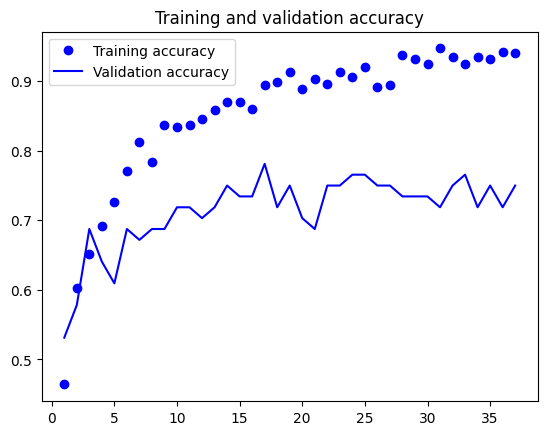

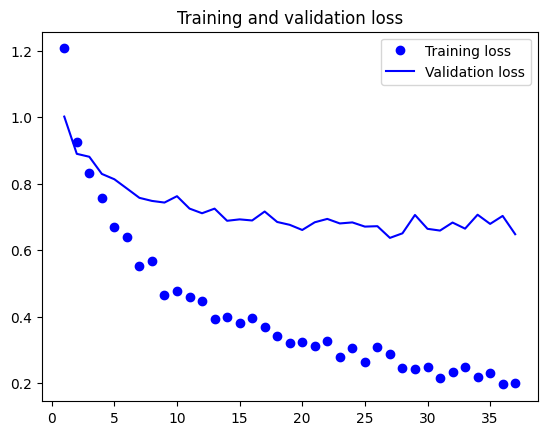

In [8]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [9]:
import time

test_model = keras.models.load_model("xception_without_dataaugmentation.keras")
test_loss, test_acc = test_model.evaluate(test_set)

start_time = time.time()
predictions = test_model.predict(test_set)
prediction_time = time.time() - start_time

print(f"Test_loss: {test_loss:.3f}")
print(f"Test_accuracy: {test_acc:.3f}")
print(f"Prediction_time:{prediction_time:.3f} seconds")

2/2 [==============================] - 1s 122ms/step
Test_loss: 0.481
Test_accuracy: 0.814
Prediction_time:1.170 seconds


In [10]:
# 데이터 증식 단계 & 밀집 분류기 추가 
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

base_model = keras.applications.xception.Xception(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)


x = base_model.output
x = data_augmentation(x)
x = keras.layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
output = keras.layers.Dense(n_classes, activation='softmax')(x)
model = keras.models.Model(inputs=base_model.input, outputs=output)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [11]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="xception_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss"),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10, 
        restore_best_weights=True  
    )
]
history = model.fit(
    train_set,
    epochs=50,
    validation_data=valid_set,
    steps_per_epoch = int(0.75 * dataset_size / batch_size),
    validation_steps = int(0.15 * dataset_size / batch_size),
    callbacks=callbacks)

Epoch 1/50
13/13 [==============================] - 37s 651ms/step - loss: 1.3934 - accuracy: 0.3462 - val_loss: 1.3532 - val_accuracy: 0.5312
Epoch 2/50
13/13 [==============================] - 7s 581ms/step - loss: 1.3153 - accuracy: 0.4615 - val_loss: 1.3151 - val_accuracy: 0.3594
Epoch 3/50
13/13 [==============================] - 8s 586ms/step - loss: 0.5918 - accuracy: 0.8053 - val_loss: 0.8810 - val_accuracy: 0.6719
Epoch 4/50
13/13 [==============================] - 7s 526ms/step - loss: 0.2113 - accuracy: 0.9135 - val_loss: 1.1008 - val_accuracy: 0.5938
Epoch 5/50
13/13 [==============================] - 8s 588ms/step - loss: 0.1471 - accuracy: 0.9447 - val_loss: 0.7502 - val_accuracy: 0.6875
Epoch 6/50
13/13 [==============================] - 7s 528ms/step - loss: 0.0722 - accuracy: 0.9784 - val_loss: 0.9318 - val_accuracy: 0.6875
Epoch 7/50
13/13 [==============================] - 7s 527ms/step - loss: 0.1090 - accuracy: 0.9615 - val_loss: 1.0177 - val_accuracy: 0.7031
Epoch

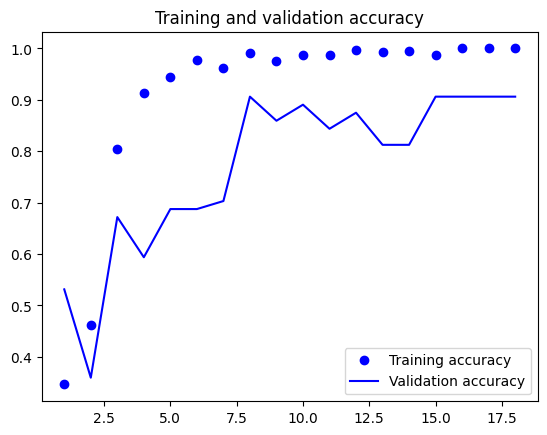

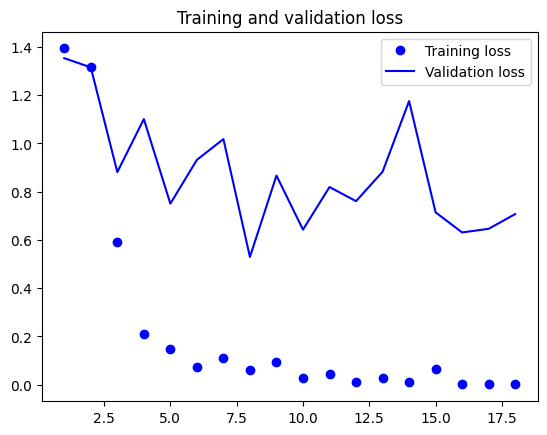

In [12]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [13]:
test_model = keras.models.load_model(
    "xception_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_set)

start_time = time.time()
predictions = test_model.predict(test_set)
prediction_time = time.time() - start_time

print(f"Test_loss: {test_loss:.3f}")
print(f"Test_accuracy: {test_acc:.3f}")
print(f"Prediction_time:{prediction_time:.3f} seconds")

2/2 [==============================] - 1s 124ms/step
Test_loss: 0.870
Test_accuracy: 0.898
Prediction_time:1.107 seconds


In [14]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

base_model = keras.applications.xception.Xception(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)


x = base_model.output
x = data_augmentation(x)
x = keras.layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
output = keras.layers.Dense(n_classes, activation='softmax')(x)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [15]:
# 모델 미세조정. 학습률을 낮게 만든다.
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss"),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10, 
        restore_best_weights=True  
    )
]
history = model.fit(
    train_set,
    epochs=50,
    validation_data=valid_set,
    steps_per_epoch = int(0.75 * dataset_size / batch_size),
    validation_steps = int(0.15 * dataset_size / batch_size),
    callbacks=callbacks)

Epoch 1/50
13/13 [==============================] - 33s 665ms/step - loss: 1.4094 - accuracy: 0.2620 - val_loss: 1.3727 - val_accuracy: 0.3594
Epoch 2/50
13/13 [==============================] - 8s 590ms/step - loss: 1.2943 - accuracy: 0.3726 - val_loss: 1.3210 - val_accuracy: 0.3750
Epoch 3/50
13/13 [==============================] - 8s 599ms/step - loss: 1.1847 - accuracy: 0.5385 - val_loss: 1.2691 - val_accuracy: 0.4375
Epoch 4/50
13/13 [==============================] - 8s 619ms/step - loss: 1.1176 - accuracy: 0.5962 - val_loss: 1.2123 - val_accuracy: 0.4688
Epoch 5/50
13/13 [==============================] - 8s 610ms/step - loss: 1.0301 - accuracy: 0.6755 - val_loss: 1.1548 - val_accuracy: 0.5156
Epoch 6/50
13/13 [==============================] - 8s 608ms/step - loss: 0.9627 - accuracy: 0.7115 - val_loss: 1.1079 - val_accuracy: 0.5469
Epoch 7/50
13/13 [==============================] - 8s 659ms/step - loss: 0.8536 - accuracy: 0.8125 - val_loss: 1.0578 - val_accuracy: 0.6406
Epoch

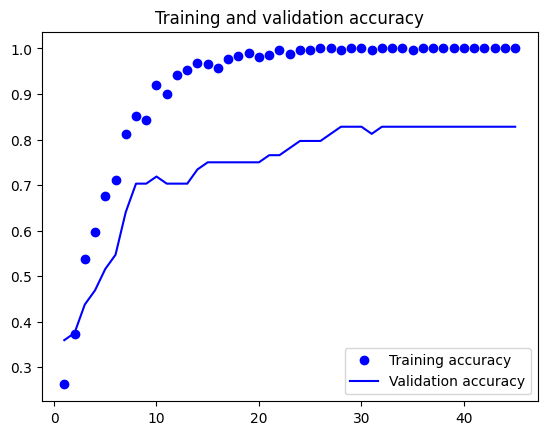

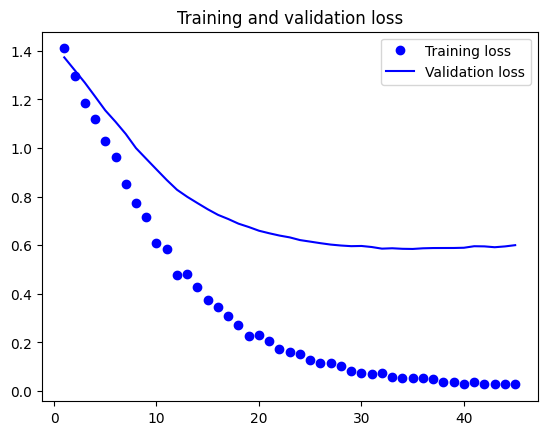

In [16]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [17]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_set)

start_time = time.time()
predictions = test_model.predict(test_set)
prediction_time = time.time() - start_time

print(f"Test_loss: {test_loss:.3f}")
print(f"Test_accuracy: {test_acc:.3f}")
print(f"Prediction_time:{prediction_time:.3f} seconds")

2/2 [==============================] - 0s 126ms/step
Test_loss: 0.385
Test_accuracy: 0.881
Prediction_time:0.333 seconds
